# Datenaufbereitung für das Autopress-Projekt

In diesem Notebook wird die Datenaufbereitung für das Autopress-Projekt durchgeführt. Die Schritte umfassen das Einlesen, die Bereinigung, die Analyse und die Vorbereitung der Daten für die Modellentwicklung.

## Überblick

Dieses Notebook folgt einem strukturierten Ansatz zur Datenvorbereitung. Ziel ist es, die Rohdaten zu verarbeiten, zu bereinigen, zu balancieren und für die Modellierung aufzubereiten. Jeder Schritt ist detailliert dokumentiert und nachvollziehbar.

### Setup

In dieser Sektion werden die benötigten Bibliotheken und Module importiert. Sie bilden die Grundlage für alle weiteren Schritte im Notebook. 

### Import

Hier werden alle wichtigen Bibliotheken und Module importiert, die für die Datenverarbeitung und -analyse erforderlich sind. Dazu gehören:

- `pandas`: Für die Datenmanipulation.
- `matplotlib` und `seaborn`: Für die Erstellung von Visualisierungen.
- `numpy`: Für numerische Berechnungen.
- `xarray`: Für die Arbeit mit multidimensionalen Daten.
- Eigene Module (`helpers`): Funktionen für das Lesen und Verarbeiten der Daten.

Durch diesen Import wird sichergestellt, dass alle nachfolgenden Schritte problemlos ausgeführt werden können.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
print("Current working directory:", os.getcwd())

Current working directory: /Users/moritz/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/Masterarbeit/Skripte Moritz/machine_learning/data_preparation


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import random
import json
import scipy.stats as stats
import sys, os

from IPython.display import display, HTML

# Der übergeordnete Ordner --> für Import von Modulen
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

# Nun funktionieren absolute Importe, z.B.:
from helpers.read_data import read_all_data
from helpers.process_data import ProcessedData, clean_data

In [3]:
# Einstellungen für Plots 
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
#%config InlineBackend.figure_format = 'svg'

## Laden der vorverarbeiteten Daten

In diesem Schritt werden die vorverarbeiteten Daten aus den bereitgestellten CSV-Dateien geladen. Diese Daten enthalten:

- Sensorbasierte Merkmale (Features)
- Temperaturmessungen
- Materialeigenschaften
- Zielgrößen (Targets) für die Modellierung

Eingaben:
- CSV-Dateien im Verzeichnis `training_data`.

Ausgabe:
- Ein `DataArray`, das die Rohdaten enthält, jedoch ohne die Spalten `Kraft1` und `Kraft2`.

### Einlesen und Bereinigen der Daten

Hier werden die Rohdaten aus den Dateien eingelesen und bereinigt. Folgende Schritte werden durchgeführt:

1. Einlesen aller relevanten Daten aus dem Ordner `training_data`.
2. Anwendung der Bereinigungsfunktionen, um fehlerhafte oder unvollständige Daten zu entfernen.
3. Erstellung eines bereinigten `DataArray`, das für die Analyse verwendet wird.

In [4]:
# Sammel alle Daten aus Dateiordner
data_before_analysis = clean_data(read_all_data(read_extra_data=True))

Reading data from /Users/moritz/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/Masterarbeit/Skripte Moritz/machine_learning/training_data/csv


### Anzeige der Spaltennamen

In dieser Zelle werden die Spaltennamen der eingelesenen Daten angezeigt. Dies dient zur Überprüfung und gibt einen Überblick über die verfügbaren Daten.

In [5]:
spalten_namen = data_before_analysis.coords['col'].values
print(spalten_namen)

['Unnamed: 0' 'Zeit' 'Berührungswerte' 'Wegmessung' 'Verkippung_1'
 'Verkippung_2' 'Verkippung_3' 'Verkippung_4' 'Stoesselhub' 'Presskraft'
 'Geschwindigkeit_UT' 'Geschwindigkeit_Ges' 'Energie_ab' 'Presskraft_dyn'
 'Motorstrom' 'Kraft1' 'Kraft2' 'Bauteil_temp_con' 'Werkzeug_temp_con'
 'Material_con' 'Position_con' 'Ergebnis_con' 'Probenhoehe'
 'richtig_verbaut' 'datei_name' 'versuchstag']


### Überprüfung der Dimensionen und Größe der Daten

Hier werden die Dimensionen und die Gesamtgröße des geladenen Datensatzes ausgegeben. Dies ist ein wichtiger Schritt, um sicherzustellen, dass die Daten korrekt geladen wurden und die erwartete Struktur aufweisen.

In [6]:
print("Dimensionen von data_before_analysis:", data_before_analysis.dims)
print("Größe von data_before_analysis:", data_before_analysis.sizes)

Dimensionen von data_before_analysis: ('versuch', 'row', 'col')
Größe von data_before_analysis: Frozen({'versuch': 702, 'row': 4816, 'col': 26})


## Erste Betrachtungen der Daten

In [7]:
# Zielspaltennamen (du kannst sie nach deinen Zielgrößen anpassen)
target_columns = ['Material_con', 'Position_con', 'Ergebnis_con', 'richtig_verbaut']

# Extrahiere die Werte aus dem DataArray
spalten_namen = data_before_analysis.coords['col'].values
versuch_ids = data_before_analysis.coords['versuch'].values

# Selektiere nur die relevanten Zielgrößen
data_selected = data_before_analysis.sel(col=target_columns)

# Aggregiere die Werte über die 'row'-Dimension
aggregated_data = {}

for target in target_columns:
    if target in spalten_namen:
        da_target = data_selected.sel(col=target)
        if np.issubdtype(da_target.dtype, np.number):
            aggregated_data[target] = da_target.mean(dim='row').values  # Mittelwert für numerische Daten
        else:
            # Bestimme den häufigsten Wert (Modus) pro Versuch
            mode_values = [pd.Series(da_target.sel(versuch=v).values).mode()[0] for v in versuch_ids]
            aggregated_data[target] = mode_values

# Erstelle DataFrame mit den aggregierten Werten
df = pd.DataFrame(aggregated_data, index=versuch_ids)

# Textuelle Ausgabe der Verteilung der Zielgrößen basierend auf der Anzahl der Versuche
for target in target_columns:
    if target in df.columns:
        print(f"Verteilung vor Balancing im Trainingsdatensatz für '{target}':")
        print(df[target].value_counts())
        print("\n")
    else:
        print(f"Warnung: {target} nicht in den Spalten von data_before_analysis enthalten.\n")

Verteilung vor Balancing im Trainingsdatensatz für 'Material_con':
Material_con
C45           308
16MnCr5       199
X20CrMoV12    195
Name: count, dtype: int64


Verteilung vor Balancing im Trainingsdatensatz für 'Position_con':
Position_con
Mitte     311
Rechts    198
schräg    193
Name: count, dtype: int64


Verteilung vor Balancing im Trainingsdatensatz für 'Ergebnis_con':
Ergebnis_con
SCHLECHT    586
GUT         116
Name: count, dtype: int64


Verteilung vor Balancing im Trainingsdatensatz für 'richtig_verbaut':
richtig_verbaut
True     378
False    324
Name: count, dtype: int64




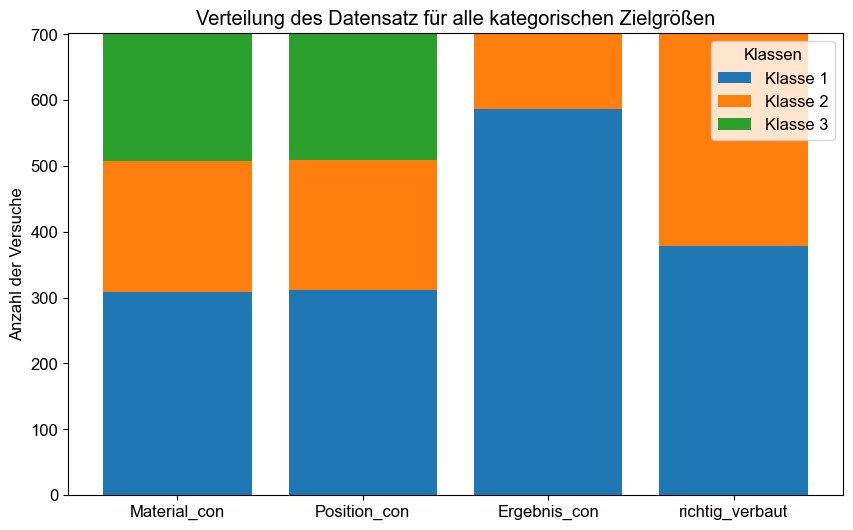

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Zielgrößen
target_columns = ['Material_con', 'Position_con', 'Ergebnis_con', 'richtig_verbaut']

# Berechnung der Verteilungen
target_distributions = {target: df[target].value_counts() for target in target_columns}

# Erstellung eines gemeinsamen Balkendiagramms für alle Zielgrößen
plt.figure(figsize=(10, 6))

# Positionen für die Gruppen
categories = list(target_distributions.keys())
x = np.arange(len(categories))

# Werte für jede Kategorie
values_list = [list(values.values) for values in target_distributions.values()]
labels_list = [list(values.index) for values in target_distributions.values()]

# Stapel-Balkendiagramm vorbereiten
bottom_values = np.zeros(len(categories))

for i in range(max(len(labels) for labels in labels_list)):  # Gehe durch die maximale Anzahl an Labels
    heights = [values[i] if i < len(values) else 0 for values in values_list]
    plt.bar(x, heights, bottom=bottom_values, label=f'Klasse {i + 1}')
    bottom_values += heights

# Achsenbeschriftungen
plt.xticks(x, categories)
plt.ylabel("Anzahl der Versuche")
plt.title("Verteilung des Datensatz für alle kategorischen Zielgrößen")
plt.legend(loc="upper right", title="Klassen")
plt.show()

## Bereinigung

In diesem Abschnitt werden irrelevante oder fehlerhafte Spalten aus den Daten entfernt. Beispielsweise:

- **Irrelevante Spalten:** `Kraft1` und `Kraft2` löschen.
- **Fehlerhafte Versuche:** einige Versuche haben fehlerhafte `Verkippung_2` Werte, diese werden aus Datensatz entfernt.

Eingaben:
- Bereinigte Rohdaten (`DataArray`).

Ausgabe:
- Ein `DataArray`, bei dem irrelevante und fehlerhafte Spalten entfernt wurden.

In [9]:
# Spaltennamen, die entfernt werden sollen
columns_to_drop = ["Kraft1", "Kraft2","Unnamed: 0"]

# Entfernen der Spalten
data_without_kraft = data_before_analysis.drop_sel(col=columns_to_drop)

# Überprüfen der Ergebnisse
spalten_namen = data_without_kraft.coords['col'].values
print(spalten_namen)

['Zeit' 'Berührungswerte' 'Wegmessung' 'Verkippung_1' 'Verkippung_2'
 'Verkippung_3' 'Verkippung_4' 'Stoesselhub' 'Presskraft'
 'Geschwindigkeit_UT' 'Geschwindigkeit_Ges' 'Energie_ab' 'Presskraft_dyn'
 'Motorstrom' 'Bauteil_temp_con' 'Werkzeug_temp_con' 'Material_con'
 'Position_con' 'Ergebnis_con' 'Probenhoehe' 'richtig_verbaut'
 'datei_name' 'versuchstag']


In [10]:
# Schritt 1: Zugriff auf Verkippung_2 aus dem vorhandenen DataArray
verkippung_2 = data_without_kraft.loc[:, :, "Verkippung_2"]

# Schritt 2: Berechnung der Differenz und Identifikation fehlerhafter Versuche
delta_verkippung_2 = abs(verkippung_2.diff(dim="row"))  # Berechne Differenz und wende abs an
fehlerhafte_versuche = (delta_verkippung_2 > 10.0).any(dim="row")  # Logische Bedingung für Fehler

# Konvertiere fehlerhafte_versuche in NumPy-Array für die Auswahl
fehlerhafte_versuche_per_versuch = fehlerhafte_versuche.values

# Schritt 3: Entfernen fehlerhafter Versuche aus dem DataArray
data_verkippung2_cleaned = data_without_kraft.sel(versuch=~fehlerhafte_versuche_per_versuch)

# Optional: Daten nach der Bereinigung überprüfen
print(f"Anzahl der entfernten Versuche: {fehlerhafte_versuche.sum().item()}")
print(f"Anzahl der verbleibenden Versuche: {len(data_verkippung2_cleaned['versuch'])}")

Anzahl der entfernten Versuche: 81
Anzahl der verbleibenden Versuche: 621


### Visualisierung: Verkippung_2 vor und nach der Bereinigung

In diesem Abschnitt wird eine grafische Analyse der Spalte `Verkippung_2` durchgeführt, um die Datenqualität vor und nach der Bereinigung zu bewerten.

Schritte:
1. Darstellung der ursprünglichen Daten von `Verkippung_2` für alle Versuche.
2. Darstellung der bereinigten Daten nach Entfernung fehlerhafter Versuche.
3. Vergleich der Anzahl der Versuche und der Werteverteilung.

Ausgabe:
- Zwei Diagramme, die `Verkippung_2` vor und nach der Bereinigung zeigen.

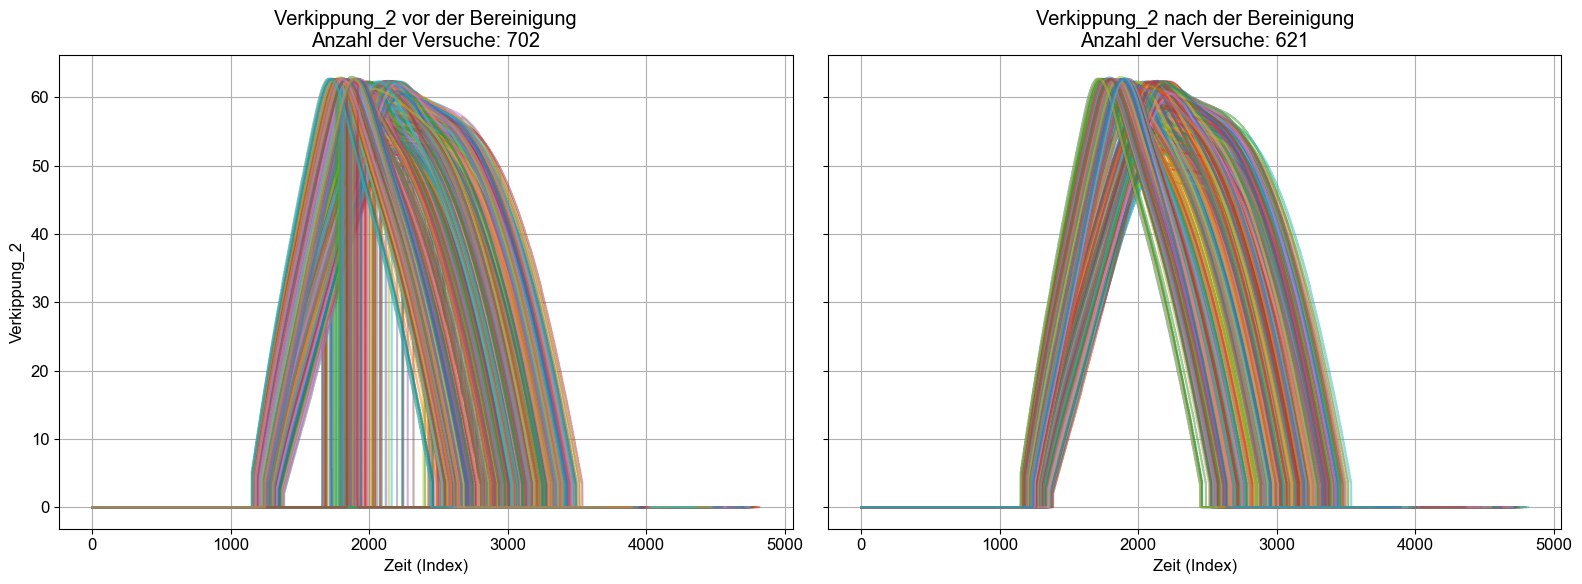

In [11]:
# Zugriff auf Verkippung_2 vor und nach der Bereinigung
verkippung_2_before = data_before_analysis.loc[:, :, "Verkippung_2"]
verkippung_2_after = data_verkippung2_cleaned.loc[:, :, "Verkippung_2"]

# Anzahl der Versuche
anzahl_versuche_before = len(data_before_analysis["versuch"])
anzahl_versuche_after = len(data_verkippung2_cleaned["versuch"])

# Plots erstellen
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot vor der Bereinigung
axs[0].set_title(f"Verkippung_2 vor der Bereinigung\nAnzahl der Versuche: {anzahl_versuche_before}")
for versuch in range(anzahl_versuche_before):
    axs[0].plot(data_before_analysis["row"], verkippung_2_before[versuch, :], alpha=0.5)
axs[0].set_xlabel("Zeit (Index)")
axs[0].set_ylabel("Verkippung_2")
axs[0].grid(True)

# Plot nach der Bereinigung
axs[1].set_title(f"Verkippung_2 nach der Bereinigung\nAnzahl der Versuche: {anzahl_versuche_after}")
for versuch in range(anzahl_versuche_after):
    axs[1].plot(data_verkippung2_cleaned["row"], verkippung_2_after[versuch, :], alpha=0.5)
axs[1].set_xlabel("Zeit (Index)")
axs[1].grid(True)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

#### Ausgabe Diagramm für Masterarbeit

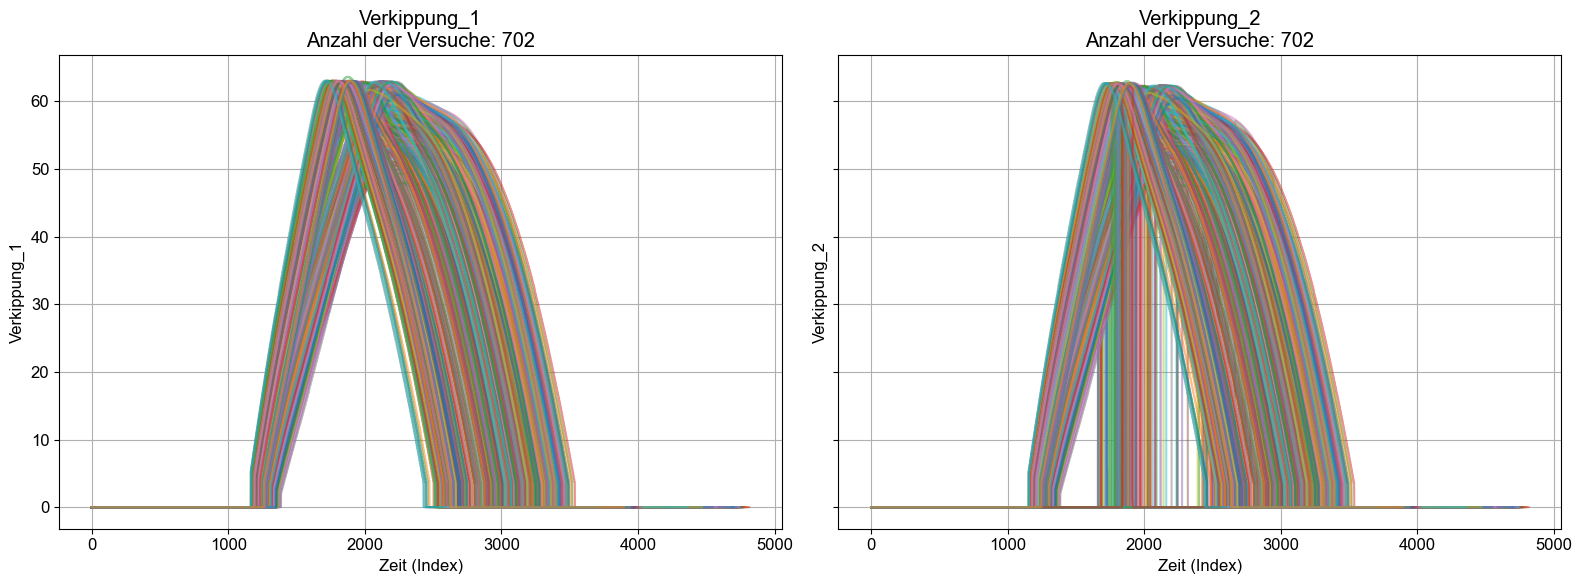

In [12]:
# Zugriff auf Verkippung_2 vor und nach der Bereinigung
verkippung_2_before = data_before_analysis.loc[:, :, "Verkippung_2"]
verkippung_1_before = data_before_analysis.loc[:, :, "Verkippung_1"]
# Anzahl der Versuche
anzahl_versuche_before = len(data_before_analysis["versuch"])

# Plots erstellen
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot Verkippung_1
axs[0].set_title(f"Verkippung_1\nAnzahl der Versuche: {anzahl_versuche_before}")
for versuch in range(anzahl_versuche_before):
    axs[0].plot(data_before_analysis["row"], verkippung_1_before[versuch, :], alpha=0.5)
axs[0].set_xlabel("Zeit (Index)")
axs[0].set_ylabel("Verkippung_1")
axs[0].grid(True)

# Plot Verkippung_2
axs[1].set_title(f"Verkippung_2\nAnzahl der Versuche: {anzahl_versuche_before}")
for versuch in range(anzahl_versuche_before):
    axs[1].plot(data_before_analysis["row"], verkippung_2_before[versuch, :], alpha=0.5)
axs[1].set_xlabel("Zeit (Index)")
axs[1].set_ylabel("Verkippung_2")
axs[1].grid(True)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

## Synchronisierung der Laserdistanzsensorik

In diesem Abschnitt werden die Daten aus verschiedenen Sensorsignalen (z. B. `Verkippung`) synchronisiert und fehlende oder inkonsistente Werte bereinigt. Ziel ist es, eine einheitliche und konsistente Datenbasis für die Analyse zu erstellen.

Schritte:
1. Synchronisierung der Verkippungssensoren: Identifikation der Start- und Endzeitpunkte, um Daten außerhalb dieser Intervalle zu bereinigen.
2. Ersetzen von Werten vor dem Startzeitpunkt und nach dem Endzeitpunkt durch `0.0`.
3. Überprüfung und Validierung der Synchronisierung.

Eingaben:
- Bereinigte Daten als `DataArray`.

Ausgabe:
- Synchronisierte Daten, bei denen die Verkippungssensoren auf konsistente Intervalle angepasst wurden.


In [13]:
# Spaltennamen der Verkippungssensoren
verkippung_sensoren = ["Verkippung_1", "Verkippung_2", "Verkippung_3", "Verkippung_4"]

# Eine Kopie der Daten erstellen
data_synchronized = data_verkippung2_cleaned.copy()

# Über die Versuche iterieren und Start- und Endzeitpunkte bestimmen
for versuch_idx in range(len(data_synchronized["versuch"])):
    # Extrahiere die Verkippungssensordaten für den aktuellen Versuch
    verkippung_daten = data_synchronized.isel(versuch=versuch_idx).sel(col=verkippung_sensoren)

    # Finde Startzeitpunkt: Der erste Index, bei dem alle Sensoren > 0 sind
    start_mask = (verkippung_daten > 0).all(dim="col")
    start_indices = np.where(start_mask)[0]
    start_index = start_indices[0] if len(start_indices) > 0 else None

    # Finde Endzeitpunkt: Der letzte Index, bei dem alle Sensoren > 0 sind
    end_indices = np.where(start_mask)[0]
    end_index = end_indices[-1] if len(end_indices) > 0 else None

    # Sicherstellen, dass Start- und Endzeitpunkte gefunden wurden
    if start_index is None or end_index is None:
        print(f"Warnung: Keine gültigen Start- oder Endzeitpunkte für Versuch {versuch_idx} gefunden.")
        continue

    # Werte vor dem Startzeitpunkt und nach dem Endzeitpunkt auf 0.0 setzen
    verkippung_daten.loc[:start_index, :] = 0.0
    verkippung_daten.loc[end_index + 1:, :] = 0.0

    # Aktualisierte Daten zurückschreiben
    data_synchronized.loc[versuch_idx, :, verkippung_sensoren] = verkippung_daten

# Optional: Überprüfe die Daten nach der Synchronisierung
print("Synchronisierung abgeschlossen.")

Synchronisierung abgeschlossen.


In [14]:
# Spaltennamen der Verkippungssensoren
verkippung_sensoren = ["Verkippung_1", "Verkippung_2", "Verkippung_3", "Verkippung_4"]

# Beispielversuche
example_versuche = [0,1]

# Zeitlicher Ausschnitt um den Startzeitpunkt
pre_start = 5  # Anzahl der Zeilen vor dem Startzeitpunkt
post_start = 5  # Anzahl der Zeilen nach dem Startzeitpunkt

# Funktion, um Startzeitpunkt zu finden
def finde_startzeitpunkt(data, sensor_columns):
    """
    Findet den Startzeitpunkt eines Versuchs, bei dem alle Verkippungssensoren > 0 sind.

    Args:
        data (xr.DataArray): Daten für einen einzelnen Versuch.
        sensor_columns (list): Liste der Verkippungssensoren.

    Returns:
        int: Der Index des Startzeitpunkts oder None, falls keiner gefunden wurde.
    """
    for idx in range(data.sizes["row"]):
        if (data.isel(row=idx).sel(col=sensor_columns).values > 0).all():
            return idx
    return None

# Tabellarische Darstellung der Daten für die Beispielversuche
for versuch_idx in example_versuche:
    # Daten für den aktuellen Versuch
    synced_data = data_synchronized.isel(versuch=versuch_idx).sel(col=verkippung_sensoren)
    unsynced_data = data_verkippung2_cleaned.isel(versuch=versuch_idx).sel(col=verkippung_sensoren)

    # Startzeitpunkt finden
    start_index = finde_startzeitpunkt(synced_data, verkippung_sensoren)
    if start_index is None:
        print(f"Kein Startzeitpunkt für Versuch {versuch_idx} gefunden!")
        continue

    # Zeitlicher Ausschnitt definieren
    start = max(start_index - pre_start, 0)
    end = min(start_index + post_start + 1, synced_data.sizes["row"])

    # Daten für den Ausschnitt extrahieren
    synced_slice = synced_data.isel(row=slice(start, end))
    unsynced_slice = unsynced_data.isel(row=slice(start, end))

    # In DataFrames konvertieren
    synced_df = pd.DataFrame(
        synced_slice.values,
        columns=synced_slice["col"].values,
        index=synced_slice["row"].values,
    )
    unsynced_df = pd.DataFrame(
        unsynced_slice.values,
        columns=unsynced_slice["col"].values,
        index=unsynced_slice["row"].values,
    )

    # Tabellen anzeigen
    print(f"Versuch {versuch_idx}: Vor der Synchronisierung")
    display(unsynced_df)

    print(f"Versuch {versuch_idx}: Nach der Synchronisierung")
    display(synced_df)

Versuch 0: Vor der Synchronisierung


,Verkippung_1,Verkippung_2,Verkippung_3,Verkippung_4
1181,0.0,0.0,5.273438,5.925926
1182,0.0,0.0,5.273438,5.925926
1183,0.0,0.0,5.273438,5.925926
1184,0.0,0.0,5.273438,5.925926
1185,5.05787,5.118634,5.797164,6.451099
1186,5.05787,5.118634,5.797164,6.451099
1187,5.05787,5.118634,5.797164,6.451099
1188,5.05787,5.118634,5.797164,6.451099
1189,5.584491,5.643807,6.320891,6.979167
1190,5.584491,5.643807,6.320891,6.979167


Versuch 0: Nach der Synchronisierung


,Verkippung_1,Verkippung_2,Verkippung_3,Verkippung_4
1181,0.0,0.0,0.0,0.0
1182,0.0,0.0,0.0,0.0
1183,0.0,0.0,0.0,0.0
1184,0.0,0.0,0.0,0.0
1185,0.0,0.0,0.0,0.0
1186,5.05787,5.118634,5.797164,6.451099
1187,5.05787,5.118634,5.797164,6.451099
1188,5.05787,5.118634,5.797164,6.451099
1189,5.584491,5.643807,6.320891,6.979167
1190,5.584491,5.643807,6.320891,6.979167


Versuch 1: Vor der Synchronisierung


,Verkippung_1,Verkippung_2,Verkippung_3,Verkippung_4
1207,0.0,4.641203,5.280671,5.931713
1208,0.0,4.641203,5.280671,5.931713
1209,0.0,4.641203,5.280671,5.931713
1210,0.0,4.641203,5.280671,5.931713
1211,5.059318,5.10706,5.784144,6.435185
1212,5.059318,5.10706,5.784144,6.435185
1213,5.059318,5.10706,5.784144,6.435185
1214,5.059318,5.10706,5.784144,6.435185
1215,5.559896,5.606193,6.276042,6.92853
1216,5.559896,5.606193,6.276042,6.92853


Versuch 1: Nach der Synchronisierung


,Verkippung_1,Verkippung_2,Verkippung_3,Verkippung_4
1207,0.0,0.0,0.0,0.0
1208,0.0,0.0,0.0,0.0
1209,0.0,0.0,0.0,0.0
1210,0.0,0.0,0.0,0.0
1211,0.0,0.0,0.0,0.0
1212,5.059318,5.10706,5.784144,6.435185
1213,5.059318,5.10706,5.784144,6.435185
1214,5.059318,5.10706,5.784144,6.435185
1215,5.559896,5.606193,6.276042,6.92853
1216,5.559896,5.606193,6.276042,6.92853


### Visualisierung: Synchronisierung der Sensoren

Dieser Abschnitt stellt die Daten vor und nach der Synchronisierung grafisch dar, um die Auswirkungen des Synchronisationsprozesses zu überprüfen.

Schritte:
1. Auswahl eines Zeitintervalls rund um den Startzeitpunkt der Synchronisation.
2. Vergleich der Rohdaten mit den synchronisierten Daten für die ausgewählten Sensoren.
3. Visualisierung der Synchronisationsergebnisse für mehrere Versuche.

Ausgabe:
- Diagramme, die die nicht synchronisierten und synchronisierten Daten nebeneinander darstellen.


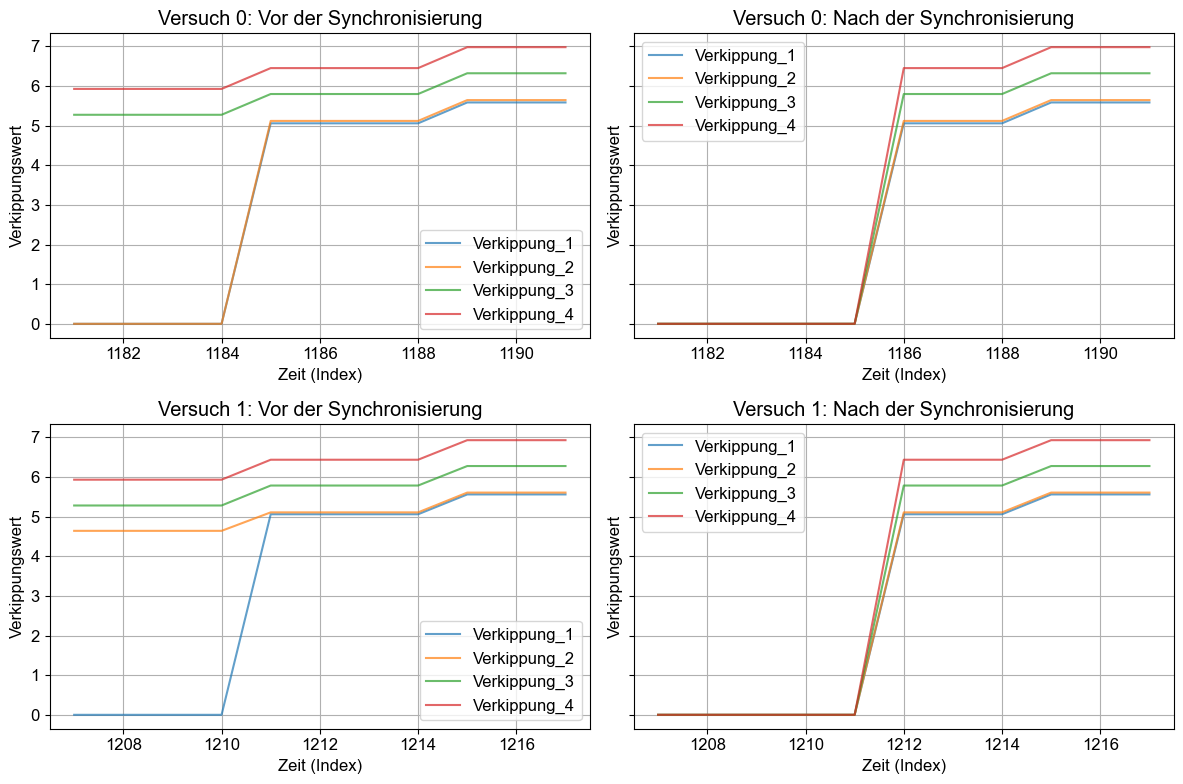

In [15]:
# Plots erstellen
fig, axs = plt.subplots(len(example_versuche), 2, figsize=(12, len(example_versuche) * 4), sharey=True)

for plot_idx, versuch_idx in enumerate(example_versuche):
    # Daten für den aktuellen Versuch
    synced_data = data_synchronized.isel(versuch=versuch_idx).sel(col=verkippung_sensoren)
    unsynced_data = data_verkippung2_cleaned.isel(versuch=versuch_idx).sel(col=verkippung_sensoren)

    # Startzeitpunkt finden
    start_index = finde_startzeitpunkt(synced_data, verkippung_sensoren)
    if start_index is None:
        print(f"Kein Startzeitpunkt für Versuch {versuch_idx} gefunden!")
        continue

    # Zeitlicher Ausschnitt definieren
    start = max(start_index - pre_start, 0)
    end = min(start_index + post_start + 1, synced_data.sizes["row"])
    plot_slice = slice(start, end)

    # Plot der nicht synchronisierten Daten
    for sensor in verkippung_sensoren:
        axs[plot_idx, 0].plot(
            unsynced_data["row"].values[plot_slice],
            unsynced_data.isel(row=plot_slice).sel(col=sensor).values,
            label=sensor,
            alpha=0.7,
        )
    axs[plot_idx, 0].set_title(f"Versuch {versuch_idx}: Vor der Synchronisierung")
    axs[plot_idx, 0].set_ylabel("Verkippungswert")
    axs[plot_idx, 0].grid(True)
    axs[plot_idx, 0].legend()

    # Plot der synchronisierten Daten
    for sensor in verkippung_sensoren:
        axs[plot_idx, 1].plot(
            synced_data["row"].values[plot_slice],
            synced_data.isel(row=plot_slice).sel(col=sensor).values,
            label=sensor,
            alpha=0.7,
        )
    axs[plot_idx, 1].set_title(f"Versuch {versuch_idx}: Nach der Synchronisierung")
    axs[plot_idx, 1].set_ylabel("Verkippungswert")
    axs[plot_idx, 1].grid(True)
    axs[plot_idx, 1].legend()

# Gemeinsame X-Achsenbeschriftung
for ax in axs.flat:
    ax.set_xlabel("Zeit (Index)")

plt.tight_layout()
plt.show()

#### Darstellung für MA

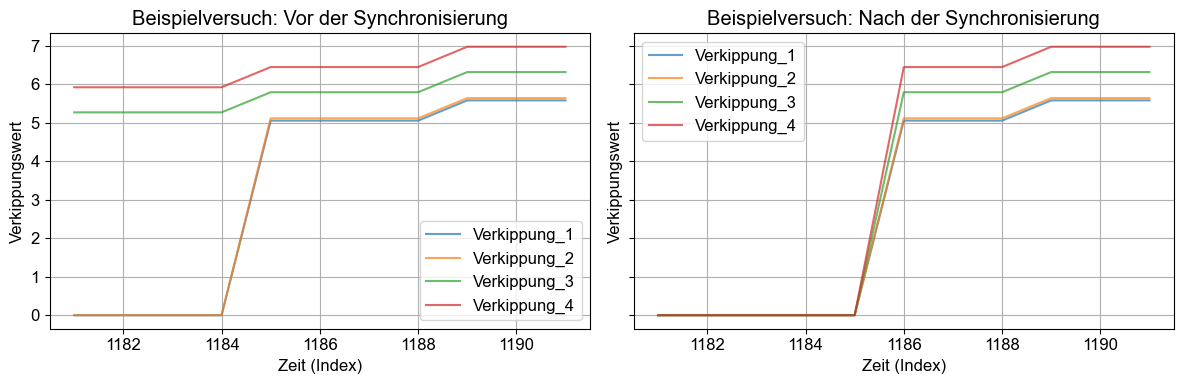

In [16]:
import matplotlib.pyplot as plt

# Definiere den gewünschten Versuch
versuch_idx = example_versuche[0]  # Wähle den ersten Versuch aus der Liste oder setze eine spezifische Zahl

# Daten für den aktuellen Versuch
synced_data = data_synchronized.isel(versuch=versuch_idx).sel(col=verkippung_sensoren)
unsynced_data = data_verkippung2_cleaned.isel(versuch=versuch_idx).sel(col=verkippung_sensoren)

# Startzeitpunkt finden
start_index = finde_startzeitpunkt(synced_data, verkippung_sensoren)
if start_index is None:
    print(f"Kein Startzeitpunkt für Versuch {versuch_idx} gefunden!")
else:
    # Zeitlicher Ausschnitt definieren
    start = max(start_index - pre_start, 0)
    end = min(start_index + post_start + 1, synced_data.sizes["row"])
    plot_slice = slice(start, end)

    # Erstelle die Plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Plot der nicht synchronisierten Daten
    for sensor in verkippung_sensoren:
        axs[0].plot(
            unsynced_data["row"].values[plot_slice],
            unsynced_data.isel(row=plot_slice).sel(col=sensor).values,
            label=sensor,
            alpha=0.7,
        )
    axs[0].set_title(f"Beispielversuch: Vor der Synchronisierung")
    axs[0].set_ylabel("Verkippungswert")
    axs[0].grid(True)
    axs[0].legend()

    # Plot der synchronisierten Daten
    for sensor in verkippung_sensoren:
        axs[1].plot(
            synced_data["row"].values[plot_slice],
            synced_data.isel(row=plot_slice).sel(col=sensor).values,
            label=sensor,
            alpha=0.7,
        )
    axs[1].set_title(f"Beispielversuch: Nach der Synchronisierung")
    axs[1].set_ylabel("Verkippungswert")
    axs[1].grid(True)
    axs[1].legend()

    # Gemeinsame X-Achsenbeschriftung
    for ax in axs:
        ax.set_xlabel("Zeit (Index)")

    plt.tight_layout()
    plt.show()

## Letzte Werte

Einige Spalten wie `Presskraft` und `Geschwindigkeit_UT` enthalten Werte, die nur am Ende des Versuchs relevant sind. In diesem Abschnitt wird jeder Versuch auf den letzten gültigen Wert in diesen Spalten reduziert.

Schritte:
1. Identifikation der letzten gültigen Werte pro Spalte und Versuch.
2. Ersetzen aller Werte in diesen Spalten durch den letzten gültigen Wert.
3. Überprüfung der Ergebnisse durch grafische Darstellung.

Eingaben:
- Synchronisierte Daten als `DataArray`.

Ausgabe:
- Ein Datensatz, bei dem `Presskraft` und `Geschwindigkeit_UT` nur noch ihren letzten gültigen Wert enthalten.


In [17]:
# Spalten, für die die letzten Werte genommen werden sollen
columns_of_interest = ["Presskraft", "Geschwindigkeit_UT"]

# Eine Kopie des DataArray erstellen, um die Änderungen zu speichern
data_last_values = data_synchronized.copy()

# Über alle Versuche iterieren
for versuch_idx in range(data_last_values.sizes["versuch"]):
    # Daten des aktuellen Versuchs extrahieren
    current_data = data_last_values.isel(versuch=versuch_idx)
    
    # Über die interessanten Spalten iterieren
    for column in columns_of_interest:
        # Werte der Spalte extrahieren
        column_values = current_data.sel(col=column).values
        
        # Werte in einen numerischen Typ konvertieren (falls möglich)
        try:
            column_values = column_values.astype(float)
        except ValueError:
            print(f"Warnung: Spalte {column} enthält nicht-numerische Werte im Versuch {versuch_idx}")
            continue
        
        # Den letzten Wert finden (der nicht `NaN` ist)
        valid_values = column_values[~np.isnan(column_values)]
        last_value = valid_values[-1] if len(valid_values) > 0 else np.nan
        
        # Alle Werte der Spalte mit dem letzten Wert überschreiben
        data_last_values.loc[dict(versuch=versuch_idx, col=column)] = last_value

### Visualisierung: Überprüfung der reduzierten Spalten

Dieser Abschnitt zeigt Diagramme für zufällig ausgewählte Versuche, um zu überprüfen, dass `Presskraft` und `Geschwindigkeit_UT` nach der Bereinigung konstant sind.

Schritte:
1. Zufällige Auswahl von 10 Versuchen.
2. Plotten der Spaltenwerte vor und nach der Bereinigung.
3. Sicherstellen, dass nur noch der letzte Wert in diesen Spalten angezeigt wird.

Ausgabe:
- Diagramme zur Überprüfung der Konsistenz.


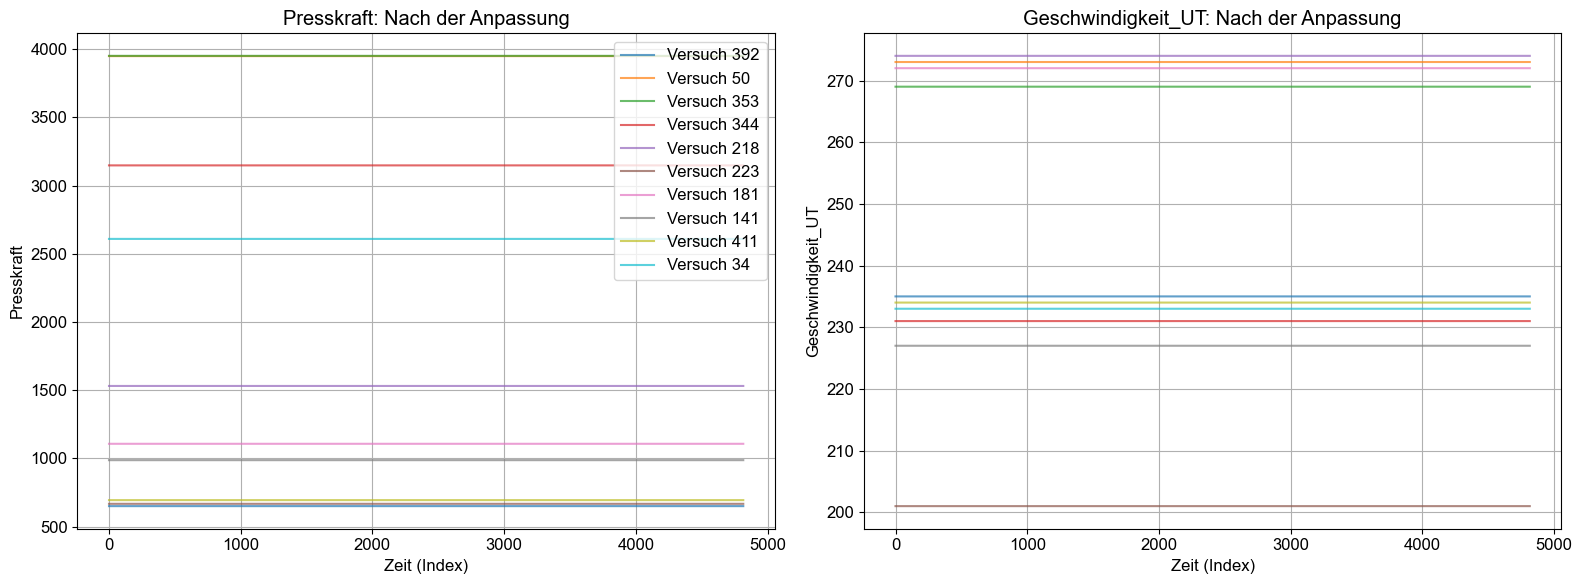

In [18]:
# Plotte 10 zufällige Versuche, um zu sehen ob nur noch ein konstanter Wert angezeigt wird. 

# Spalten, die wir plotten möchten
columns_to_plot = ["Presskraft", "Geschwindigkeit_UT"]

# Nachher-Daten aus dem modifizierten DataArray
data_constant = data_last_values

# Zufällige Auswahl von 10 Versuchen
random_versuche = random.sample(range(len(data_constant["versuch"])), 10)

# Plot erstellen
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

for col_idx, column in enumerate(columns_to_plot):
    for versuch_idx in random_versuche:
        # Nachher-Daten plotten
        axs[col_idx].plot(
            data_constant["row"],
            data_constant.isel(versuch=versuch_idx).sel(col=column).values,
            alpha=0.7,
            label=f"Versuch {versuch_idx}",
        )

    axs[col_idx].set_title(f"{column}: Nach der Anpassung")
    axs[col_idx].set_xlabel("Zeit (Index)")
    axs[col_idx].set_ylabel(column)
    axs[col_idx].grid(True)

# Nur die Legende einmalig anzeigen
handles, labels = axs[0].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
axs[0].legend(unique_labels.values(), unique_labels.keys(), loc="upper right")

# Layout und Anzeige
plt.tight_layout()
plt.show()

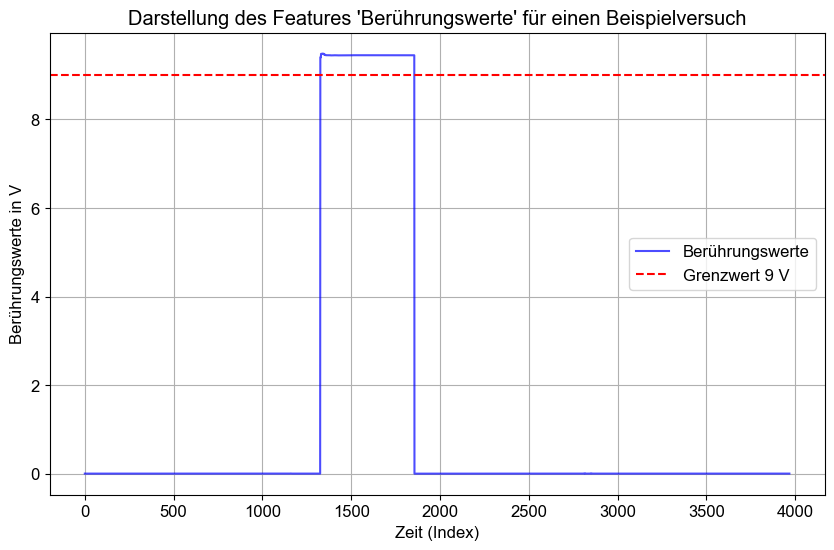

In [28]:
# Definiere den gewünschten Versuch
example_versuch = 0  # Wähle den Index des Beispielversuchs

# Wähle das Feature "Berührungswerte" aus
feature_name = "Berührungswerte"

# Extrahiere die Werte für den Beispielversuch und das Feature
example_data = data_synchronized.sel(col=feature_name).isel(versuch=example_versuch)

# Erstelle den Plot

plt.figure(figsize=(10, 6))
plt.plot(data_synchronized["row"], example_data, label=feature_name, color='blue', alpha=0.7)
plt.axhline(y=9, color='red', linestyle='--', label='Grenzwert 9 V')
plt.title(f"Darstellung des Features '{feature_name}' für einen Beispielversuch")
plt.xlabel("Zeit (Index)")
plt.ylabel(feature_name + " in V")
plt.grid(True)
plt.legend()
plt.savefig("Berührungswerte.svg", format="svg")
plt.show()

### Probenhöhe und Temperatur runden


In [20]:

# Extrahiere die Werte aus der Spalte und konvertiere sie in floats
probenhoehe_values = data_constant.sel(col="Probenhoehe").values.astype(float)

# Runde die Werte auf 3 Nachkommastellen
probenhoehe_values_rounded = np.round(probenhoehe_values, 3)

# Aktualisiere die Spalte "Probenhoehe" mit den gerundeten Werten
data_constant.loc[:, :, "Probenhoehe"] = probenhoehe_values_rounded

# Überprüfen, ob die Werte korrekt gerundet wurden
print(data_constant.sel(col="Probenhoehe").values)

[[38.23 38.23 38.23 ... nan nan nan]
 [40.35 40.35 40.35 ... nan nan nan]
 [40.14 40.14 40.14 ... nan nan nan]
 ...
 [39.82 39.82 39.82 ... nan nan nan]
 [39.57 39.57 39.57 ... nan nan nan]
 [39.83 39.83 39.83 ... nan nan nan]]


In [21]:
# Extrahiere die Werte aus der Spalte und konvertiere sie in floats
bauteil_temp_values = data_constant.sel(col="Bauteil_temp_con").values.astype(float)
werkzeug_temp_values = data_constant.sel(col="Werkzeug_temp_con").values.astype(float)

# Runde die Werte auf 3 Nachkommastellen
bauteil_temp_values_rounded = np.round(bauteil_temp_values, 2)
werkzeug_temp_values_rounded = np.round(werkzeug_temp_values, 2)

# Aktualisiere die Spalten "Bauteil_Temp" und "Werkzeug_temp_con" mit den gerundeten Werten
data_constant.loc[:, :, "Bauteil_temp_con"] = bauteil_temp_values_rounded
data_constant.loc[:, :, "Werkzeug_temp_con"] = werkzeug_temp_values_rounded

# Überprüfen, ob die Werte korrekt gerundet wurden
print(data_constant.sel(col="Bauteil_temp_con").values)
print(data_constant.sel(col="Werkzeug_temp_con").values)

[[1144.01 1144.01 1144.01 ... nan nan nan]
 [1079.46 1079.46 1079.46 ... nan nan nan]
 [1163.72 1163.72 1163.72 ... nan nan nan]
 ...
 [1221.31 1221.31 1221.31 ... nan nan nan]
 [1237.3 1237.3 1237.3 ... nan nan nan]
 [1235.61 1235.61 1235.61 ... nan nan nan]]
[[52.26 52.26 52.26 ... nan nan nan]
 [53.28 53.28 53.28 ... nan nan nan]
 [46.89 46.89 46.89 ... nan nan nan]
 ...
 [59.34 59.34 59.34 ... nan nan nan]
 [65.7 65.7 65.7 ... nan nan nan]
 [62.84 62.84 62.84 ... nan nan nan]]


## Transformation kategorischer Labels 

In diesem Schritt werden kategorische Variablen wie `Material_con`, `Position_con`, `Ergebnis_con` und `richtig_verbaut` in numerische Werte umgewandelt. Diese Transformation ist notwendig, um die Daten in maschinelle Lernmodelle einzuspeisen.

Schritte:
1. Erstellung eines Mappings, das jedem kategorialen Wert eine eindeutige Zahl zuordnet.
2. Anwendung des Mappings auf die entsprechenden Spalten im Datensatz.
3. Speicherung der Mapping-Informationen zur späteren Rücktransformation.

Eingaben:
- Datensatz mit kategorischen Labels.

Ausgabe:
- Datensatz mit numerischen Werten für kategorische Spalten.
- Mapping-Informationen als JSON-Datei.

In [22]:
# Transformation der Labels von kategorischen in numerische

# Kopiere das DataArray, um Transformationen durchzuführen
data_transformed = data_constant.copy()

# Spalten mit kategorischen Werten
categorical_columns = ["Material_con", "Position_con", "Ergebnis_con", "richtig_verbaut"]

# Mapping-Dictionary initialisieren
label_mappings = {}

# Über alle kategorischen Spalten iterieren
for col in categorical_columns:
    # Werte der aktuellen Spalte extrahieren
    spaltenwerte = data_transformed.sel(col=col).values

    try:
        # Prüfen, ob Werte numerisch sind
        spaltenwerte = spaltenwerte.astype(str)  # Alle Werte in Strings umwandeln, um Konsistenz sicherzustellen
    except ValueError:
        print(f"Spalte {col} enthält nicht-numerische Werte und wird übersprungen.")
        continue

    # Einzigartige Werte identifizieren (flach, ohne nan)
    unique_values = np.unique(spaltenwerte.flatten())
    unique_values = [val for val in unique_values if val != "nan"]  # `nan`-Werte ausschließen

    # Mapping erstellen (jeder Kategorie eine Zahl zuordnen)
    col_mapping = {val: idx for idx, val in enumerate(unique_values)}

    # Spezielle Behandlung für `nan`
    col_mapping["nan"] = -1

    # Mapping speichern
    label_mappings[col] = col_mapping

    # Numerische Werte zuweisen
    numeric_values = [col_mapping.get(str(val), -1) for val in spaltenwerte.flatten()]
    numeric_values = np.array(numeric_values).reshape(spaltenwerte.shape)  # Originalform wiederherstellen

    data_transformed.loc[:, :, col] = numeric_values

# Optional: Mapping speichern
with open("./mappings/label_mappings.json", "w") as f:
    json.dump(label_mappings, f)

print("Transformation abgeschlossen.")

KeyboardInterrupt: 

In [ ]:
def vereinheitliche_labels(data: xr.DataArray, label_columns: list) -> xr.DataArray:
    """
    Vereinheitlicht die Labels in den angegebenen Spalten, indem der Wert der ersten Zeile 
    eines Versuchs für den gesamten Versuch übernommen wird.

    Args:
        data (xr.DataArray): Das Input-DataArray.
        label_columns (list): Liste der Spalten mit Labels, die vereinheitlicht werden sollen.

    Returns:
        xr.DataArray: Das aktualisierte DataArray mit vereinheitlichten Labels.
    """
    # Iteriere über alle Spalten, die vereinheitlicht werden sollen
    for col in label_columns:
        # Extrahiere die Werte der Spalte
        spaltenwerte = data.sel(col=col).values
        
        # Hol den ersten Wert jedes Versuchs und wiederhole ihn über alle Zeilen
        vereinheitlichte_werte = np.expand_dims(spaltenwerte[:, 0], axis=1)
        vereinheitlichte_werte = np.repeat(vereinheitlichte_werte, spaltenwerte.shape[1], axis=1)
        
        # Überschreibe die Spalte im DataArray
        data.loc[:, :, col] = vereinheitlichte_werte

    return data


# Beispielverwendung
label_columns = ["Material_con", "Position_con", "Ergebnis_con", "richtig_verbaut"]
data_transformed = vereinheitliche_labels(data_transformed, label_columns)

# Debugging: Überprüfen der Änderungen
for col in label_columns:
    print(f"Spalte '{col}':")
    print(data_transformed.sel(col=col).values[:5, :5])  # Zeige die ersten 5 Werte der ersten 5 Versuche

Spalte 'Material_con':
[[2 2 2 2 2]
 [2 2 2 2 2]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 0 0 0]]
Spalte 'Position_con':
[[1 1 1 1 1]
 [2 2 2 2 2]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [1 1 1 1 1]]
Spalte 'Ergebnis_con':
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Spalte 'richtig_verbaut':
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [ ]:
# Transformation der Labels von kategorischen in numerische

# Kopiere das DataArray, um Transformationen durchzuführen
data_transformed_binary = data_constant.copy()

# Spalten mit kategorischen Werten
categorical_columns = ["Material_con", "Position_con", "Ergebnis_con", "richtig_verbaut"]

# Mapping-Dictionary initialisieren
label_mappings = {}

# Über alle kategorischen Spalten iterieren
for col in categorical_columns:
    # Werte der aktuellen Spalte extrahieren
    spaltenwerte = data_transformed_binary.sel(col=col).values

    try:
        # Prüfen, ob Werte numerisch sind
        spaltenwerte = spaltenwerte.astype(str)  # Alle Werte in Strings umwandeln, um Konsistenz sicherzustellen
    except ValueError:
        print(f"Spalte {col} enthält nicht-numerische Werte und wird übersprungen.")
        continue

    # Behandlung von `Material_con`: Binäre Transformation
    if col == "Material_con":
        col_mapping = {"X20CrMoV12": 0}  # "X20CrMoV12" wird zu 0
        # Restliche Kategorien werden zu 1
        col_mapping.update({val: 1 for val in np.unique(spaltenwerte.flatten()) if val != "X20CrMoV12"})
        col_mapping["nan"] = -1  # `nan`-Werte behandeln

    # Behandlung von `Position_con`: Binäre Transformation
    elif col == "Position_con":
        col_mapping = {"Mitte": 1}  # "Mitte" wird zu 1
        # Restliche Kategorien werden zu 0
        col_mapping.update({val: 0 for val in np.unique(spaltenwerte.flatten()) if val != "Mitte"})
        col_mapping["nan"] = -1  # `nan`-Werte behandeln

    # Behandlung von `Ergebnis_con`: Binäre Transformation
    elif col == "Ergebnis_con":
        col_mapping = {"GUT": 1, "SCHLECHT": 0}  # "GUT" wird zu 1, "SCHLECHT" zu 0
        col_mapping["nan"] = -1  # `nan`-Werte behandeln

    else:
        # Einzigartige Werte identifizieren (flach, ohne nan)
        unique_values = np.unique(spaltenwerte.flatten())
        unique_values = [val for val in unique_values if val != "nan"]  # `nan`-Werte ausschließen

        # Mapping erstellen (jeder Kategorie eine Zahl zuordnen)
        col_mapping = {val: idx for idx, val in enumerate(unique_values)}
        col_mapping["nan"] = -1  # `nan`-Werte behandeln

    # Mapping speichern
    label_mappings[col] = col_mapping

    # Numerische Werte zuweisen
    numeric_values = [col_mapping.get(str(val), -1) for val in spaltenwerte.flatten()]
    numeric_values = np.array(numeric_values).reshape(spaltenwerte.shape)  # Originalform wiederherstellen

    data_transformed_binary.loc[:, :, col] = numeric_values

# Optional: Mapping speichern
with open("./mappings/label_mappings_binary.json", "w") as f:
    json.dump(label_mappings, f)

print("Binäre Transformation abgeschlossen.")

Binäre Transformation abgeschlossen.


In [ ]:
# Zielspaltennamen (du kannst sie nach deinen Zielgrößen anpassen)
target_columns = ['Material_con', 'Position_con', 'Ergebnis_con', 'richtig_verbaut']

# Extrahiere die Werte aus dem DataArray
spalten_namen = data_transformed_binary.coords['col'].values
versuch_ids = data_transformed_binary.coords['versuch'].values

# Selektiere nur die relevanten Zielgrößen
data_selected = data_transformed_binary.sel(col=target_columns)

# Aggregiere die Werte über die 'row'-Dimension
aggregated_data = {}

for target in target_columns:
    if target in spalten_namen:
        da_target = data_selected.sel(col=target)
        if np.issubdtype(da_target.dtype, np.number):
            aggregated_data[target] = da_target.mean(dim='row').values  # Mittelwert für numerische Daten
        else:
            # Bestimme den häufigsten Wert (Modus) pro Versuch
            mode_values = [pd.Series(da_target.sel(versuch=v).values).mode()[0] for v in versuch_ids]
            aggregated_data[target] = mode_values

# Erstelle DataFrame mit den aggregierten Werten
df = pd.DataFrame(aggregated_data, index=versuch_ids)

# Textuelle Ausgabe der Verteilung der Zielgrößen basierend auf der Anzahl der Versuche
for target in target_columns:
    if target in df.columns:
        print(f"Verteilung vor Balancing im Trainingsdatensatz für '{target}':")
        print(df[target].value_counts())
        print("\n")
    else:
        print(f"Warnung: {target} nicht in den Spalten von data_before_analysis enthalten.\n")

Verteilung vor Balancing im Trainingsdatensatz für 'Material_con':
Material_con
1    444
0    177
Name: count, dtype: int64


Verteilung vor Balancing im Trainingsdatensatz für 'Position_con':
Position_con
0    355
1    266
Name: count, dtype: int64


Verteilung vor Balancing im Trainingsdatensatz für 'Ergebnis_con':
Ergebnis_con
0    532
1     89
Name: count, dtype: int64


Verteilung vor Balancing im Trainingsdatensatz für 'richtig_verbaut':
richtig_verbaut
1    351
0    270
Name: count, dtype: int64




#### Visualisierung

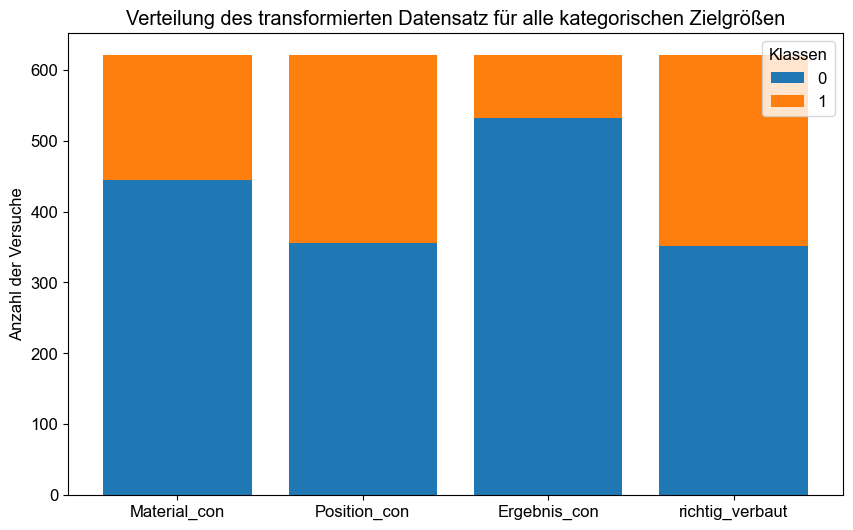

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Zielgrößen
target_columns = ['Material_con', 'Position_con', 'Ergebnis_con', 'richtig_verbaut']

# Berechnung der Verteilungen
target_distributions = {target: df[target].value_counts() for target in target_columns}

# Erstellung eines gemeinsamen Balkendiagramms für alle Zielgrößen
plt.figure(figsize=(10, 6))

# Positionen für die Gruppen
categories = list(target_distributions.keys())
x = np.arange(len(categories))

# Werte für jede Kategorie
values_list = [list(values.values) for values in target_distributions.values()]
labels_list = [list(values.index) for values in target_distributions.values()]

# Stapel-Balkendiagramm vorbereiten
bottom_values = np.zeros(len(categories))

for i in range(max(len(labels) for labels in labels_list)):  # Gehe durch die maximale Anzahl an Labels
    heights = [values[i] if i < len(values) else 0 for values in values_list]
    plt.bar(x, heights, bottom=bottom_values, label=f'{i}')
    bottom_values += heights

# Achsenbeschriftungen
plt.xticks(x, categories)
plt.ylabel("Anzahl der Versuche")
plt.title("Verteilung des transformierten Datensatz für alle kategorischen Zielgrößen")
plt.legend(loc="upper right", title="Klassen")
plt.show()


### Überprüfung: Rücktransformation numerischer Labels

Dieser Abschnitt überprüft die Richtigkeit der Transformation, indem die numerischen Werte wieder in ihre ursprünglichen Labels zurückgeführt werden.

Schritte:
1. Auswahl eines Beispiels aus den transformierten Daten.
2. Rücktransformation der numerischen Werte in ihre ursprünglichen Kategorien.
3. Vergleich der originalen Labels, der numerischen Werte und der rücktransformierten Labels.

Ausgabe:
- Tabellarische Übersicht zur Überprüfung der Transformation.

In [ ]:
import pickle
# Definiertes DataArray
data = data_transformed_binary
with open('data_transformed_binary.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
# Funktion zur Rücktransformation (numerische Werte zurück in Labels umwandeln)
def reverse_transform(data, label_mappings, column, example_versuch, num_rows_to_check):
    numeric_values = data.sel(col=column).isel(versuch=example_versuch).values[:num_rows_to_check]
    reverse_mapping = {v: k for k, v in label_mappings[column].items()}
    original_values = np.array([reverse_mapping.get(val, "Unknown") for val in numeric_values])
    return original_values

# Beispielwerte überprüfen
example_column = "Material_con"  # Zu überprüfende Spalte
example_versuch = 0  # Beispielversuch
num_rows_to_check = 10  # Anzahl der zu überprüfenden Zeilen

# Originalwerte extrahieren
original_values = data_constant.sel(col=example_column).isel(versuch=example_versuch).values[:num_rows_to_check]
numeric_values = data_transformed_binary.sel(col=example_column).isel(versuch=example_versuch).values[:num_rows_to_check]

# Rücktransformation der numerischen Werte
reversed_values = reverse_transform(
    data_transformed_binary, label_mappings, example_column, example_versuch, num_rows_to_check
)

# Ausgabe
print(f"Überprüfung der Transformation für Spalte: {example_column}")
print(f"{'Originalwert':<15}{'Numerischer Wert':<20}{'Rücktransformiert'}")
print("-" * 50)
for orig, num, rev in zip(original_values, numeric_values, reversed_values):
    print(f"{str(orig):<15}{str(num):<20}{str(rev)}")

Überprüfung der Transformation für Spalte: Material_con
Originalwert   Numerischer Wert    Rücktransformiert
--------------------------------------------------
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12
X20CrMoV12     0                   X20CrMoV12


### Überprüfung auf numerische Werte in allen Spalten

In diesem Abschnitt wird überprüft, ob alle Werte in den Spalten des Datensatzes numerisch sind. Nicht-numerische Spalten können problematisch sein, wenn sie in Modellen verwendet werden, die nur numerische Eingaben akzeptieren.

Schritte:
1. Iteration über alle Spalten des Datensatzes.
2. Versuch, die Werte jeder Spalte in `float` zu konvertieren.
3. Identifikation nicht-numerischer Spalten und Ausgabe eines Hinweises für diese Spalten.

Ergebnis:
- Es wird eine Liste erstellt, die angibt, ob jede Spalte numerische Werte enthält oder nicht.
- Nicht-numerische Spalten werden identifiziert, um sie gezielt zu bearbeiten oder zu entfernen.


In [ ]:
# Überprüfen, ob alle Werte numerisch sind
for col in data_transformed["col"].values:
    try:
        # Extrahiere die Spaltenwerte und überprüfe den Datentyp
        spaltenwerte = data_transformed.sel(col=col).values
        # Versuche die Werte in float zu konvertieren
        spaltenwerte.astype(float)
        print(f"Spalte '{col}' ist numerisch.")
    except ValueError:
        # Wenn ein Fehler auftritt, sind nicht-numerische Werte enthalten
        print(f"Spalte '{col}' enthält nicht-numerische Werte.")
    except Exception as e:
        # Allgemeiner Fehlerfall (falls notwendig)
        print(f"Fehler bei der Überprüfung der Spalte '{col}': {e}")

Spalte 'Zeit' ist numerisch.
Spalte 'Berührungswerte' ist numerisch.
Spalte 'Wegmessung' ist numerisch.
Spalte 'Verkippung_1' ist numerisch.
Spalte 'Verkippung_2' ist numerisch.
Spalte 'Verkippung_3' ist numerisch.
Spalte 'Verkippung_4' ist numerisch.
Spalte 'Stoesselhub' ist numerisch.
Spalte 'Presskraft' ist numerisch.
Spalte 'Geschwindigkeit_UT' ist numerisch.
Spalte 'Geschwindigkeit_Ges' ist numerisch.
Spalte 'Energie_ab' ist numerisch.
Spalte 'Presskraft_dyn' ist numerisch.
Spalte 'Motorstrom' ist numerisch.
Spalte 'Bauteil_temp_con' ist numerisch.
Spalte 'Werkzeug_temp_con' ist numerisch.
Spalte 'Material_con' ist numerisch.
Spalte 'Position_con' ist numerisch.
Spalte 'Ergebnis_con' ist numerisch.
Spalte 'Probenhoehe' ist numerisch.
Spalte 'richtig_verbaut' ist numerisch.
Spalte 'datei_name' enthält nicht-numerische Werte.
Spalte 'versuchstag' enthält nicht-numerische Werte.


### Entfernen einer nicht-numerischen Spalte

In diesem Schritt wird die Spalte `versuchstag`, die nicht-numerische Werte enthält und für die Analyse nicht benötigt wird, aus dem Datensatz entfernt.

Schritte:
1. Überprüfung des Namens der nicht-numerischen Spalte (`versuchstag`).
2. Entfernung dieser Spalte aus dem Datensatz.

Ergebnis:
- Der bereinigte Datensatz ohne die Spalte `versuchstag`.


In [ ]:
# Entferne nicht-numerische Spalten aus dem DataArray
data_transformed = data_transformed.drop_sel(col='versuchstag')


### Transformation der Spalte `datei_name` in numerische Werte

In diesem Abschnitt wird die Spalte `datei_name`, die kategoriale oder nicht-numerische Werte enthält, in numerische Werte transformiert. Diese Transformation ist notwendig, um die Daten in numerischen Modellen verwenden zu können.

Schritte:
1. **Extraktion der Werte**: Alle Werte aus der Spalte `datei_name` werden extrahiert.
2. **Debugging**: Überprüfung der Form und Struktur der Werte in der Spalte.
3. **Behandlung von `nan`-Werten**: Fehlende Werte (`nan`) werden durch einen Platzhalter ersetzt (`"nan_placeholder"`).
4. **Sicherstellung der Datentypen**: Alle Werte werden in Strings umgewandelt.
5. **Mapping erstellen**: Ein Mapping wird erstellt, das jedem eindeutigen Wert eine eindeutige Zahl zuordnet.
6. **Transformation der Werte**: Die ursprünglichen Werte werden basierend auf dem Mapping in numerische Werte transformiert.
7. **Rückführung in die ursprüngliche Struktur**: Falls die Spalte ursprünglich mehrdimensional war, wird die Struktur nach der Transformation wiederhergestellt.
8. **Aktualisierung des Datensatzes**: Die transformierten Werte werden in den Datensatz eingefügt.

Ergebnis:
- Die Spalte `datei_name` ist erfolgreich in numerische Werte transformiert.
- Ein Mapping wird erstellt, um die ursprünglichen Werte nach Bedarf rekonstruieren zu können.

Debugging-Hinweise:
- Die Form und erste Werte der Spalte werden vor der Transformation überprüft.
- Das Mapping der Werte wird zur Validierung ausgegeben.

In [ ]:
# Transformation von `datei_name`
col = "datei_name"

# Extrahiere Werte der Spalte
spaltenwerte = data.sel(col=col).values

# Debugging: Überprüfen der Struktur
print(f"Shape von '{col}': {spaltenwerte.shape}")
print(f"Erste Werte von '{col}': {spaltenwerte[:5]}")

# Falls mehrdimensional, flach machen
if spaltenwerte.ndim > 1:
    spaltenwerte = spaltenwerte.flatten()

# `nan`-Werte durch einen eindeutigen Platzhalter ersetzen
spaltenwerte = np.where(pd.isnull(spaltenwerte), "nan_placeholder", spaltenwerte)

# Sicherstellen, dass alle Werte Strings sind
spaltenwerte = spaltenwerte.astype(str)

# Einzigartige Werte finden
unique_values = np.unique(spaltenwerte)

# Mapping erstellen
col_mapping = {val: idx for idx, val in enumerate(unique_values)}
print(f"Mapping für Spalte '{col}': {col_mapping}")

# Werte transformieren
transformed_values = np.array([col_mapping[val] for val in spaltenwerte])

# Werte zurück in die ursprüngliche Form bringen (falls mehrdimensional)
if data.sel(col=col).values.ndim > 1:
    transformed_values = transformed_values.reshape(data.sel(col=col).values.shape)

# Aktualisieren des DataArray
data.loc[:, :, col] = transformed_values

print(f"Spalte '{col}' erfolgreich transformiert.")

# Dateipfad für das Mapping
mapping_file = "./mappings/datei_name_mapping.json"

# Mapping speichern
with open(mapping_file, "w") as f:
    json.dump(col_mapping, f)

print(f"Mapping erfolgreich gespeichert unter: {mapping_file}")

Shape von 'datei_name': (621, 4816)
Erste Werte von 'datei_name': [['Autopress_2023-12-14_13-40-53_330156.csv'
  'Autopress_2023-12-14_13-40-53_330156.csv'
  'Autopress_2023-12-14_13-40-53_330156.csv' ... nan nan nan]
 ['Autopress_2023-12-14_09-37-45_284435.csv'
  'Autopress_2023-12-14_09-37-45_284435.csv'
  'Autopress_2023-12-14_09-37-45_284435.csv' ... nan nan nan]
 ['Autopress_2023-12-14_11-44-32_652190.csv'
  'Autopress_2023-12-14_11-44-32_652190.csv'
  'Autopress_2023-12-14_11-44-32_652190.csv' ... nan nan nan]
 ['Autopress_2023-12-14_13-32-37_645926.csv'
  'Autopress_2023-12-14_13-32-37_645926.csv'
  'Autopress_2023-12-14_13-32-37_645926.csv' ... nan nan nan]
 ['Autopress_2023-12-14_13-39-43_842080.csv'
  'Autopress_2023-12-14_13-39-43_842080.csv'
  'Autopress_2023-12-14_13-39-43_842080.csv' ... nan nan nan]]
Mapping für Spalte 'datei_name': {'Autopress_2023-12-06_11-06-50_110570.csv': 0, 'Autopress_2023-12-06_14-52-23_386564.csv': 1, 'Autopress_2023-12-06_14-53-22_875569.csv': 2

In [ ]:
# Überprüfung der Transformation
print(f"Erste transformierte Werte in '{col}': {data_transformed.sel(col=col).values[:10]}")

Erste transformierte Werte in 'datei_name': [['Autopress_2023-12-14_13-40-53_330156.csv'
  'Autopress_2023-12-14_13-40-53_330156.csv'
  'Autopress_2023-12-14_13-40-53_330156.csv' ... nan nan nan]
 ['Autopress_2023-12-14_09-37-45_284435.csv'
  'Autopress_2023-12-14_09-37-45_284435.csv'
  'Autopress_2023-12-14_09-37-45_284435.csv' ... nan nan nan]
 ['Autopress_2023-12-14_11-44-32_652190.csv'
  'Autopress_2023-12-14_11-44-32_652190.csv'
  'Autopress_2023-12-14_11-44-32_652190.csv' ... nan nan nan]
 ...
 ['Autopress_2023-12-14_11-48-32_750310.csv'
  'Autopress_2023-12-14_11-48-32_750310.csv'
  'Autopress_2023-12-14_11-48-32_750310.csv' ... nan nan nan]
 ['Autopress_2023-12-14_12-53-32_495285.csv'
  'Autopress_2023-12-14_12-53-32_495285.csv'
  'Autopress_2023-12-14_12-53-32_495285.csv' ... nan nan nan]
 ['Autopress_2023-12-14_11-52-54_334735.csv'
  'Autopress_2023-12-14_11-52-54_334735.csv'
  'Autopress_2023-12-14_11-52-54_334735.csv' ... nan nan nan]]


In [ ]:
# Überprüfen, ob alle Werte numerisch sind
for col in data_transformed["col"].values:
    try:
        # Extrahiere die Spaltenwerte und überprüfe den Datentyp
        spaltenwerte = data_transformed.sel(col=col).values
        # Versuche die Werte in float zu konvertieren
        spaltenwerte.astype(float)
        print(f"Spalte '{col}' ist numerisch.")
    except ValueError:
        # Wenn ein Fehler auftritt, sind nicht-numerische Werte enthalten
        print(f"Spalte '{col}' enthält nicht-numerische Werte.")
    except Exception as e:
        # Allgemeiner Fehlerfall (falls notwendig)
        print(f"Fehler bei der Überprüfung der Spalte '{col}': {e}")

Spalte 'Zeit' ist numerisch.
Spalte 'Berührungswerte' ist numerisch.
Spalte 'Wegmessung' ist numerisch.
Spalte 'Verkippung_1' ist numerisch.
Spalte 'Verkippung_2' ist numerisch.
Spalte 'Verkippung_3' ist numerisch.
Spalte 'Verkippung_4' ist numerisch.
Spalte 'Stoesselhub' ist numerisch.
Spalte 'Presskraft' ist numerisch.
Spalte 'Geschwindigkeit_UT' ist numerisch.
Spalte 'Geschwindigkeit_Ges' ist numerisch.
Spalte 'Energie_ab' ist numerisch.
Spalte 'Presskraft_dyn' ist numerisch.
Spalte 'Motorstrom' ist numerisch.
Spalte 'Bauteil_temp_con' ist numerisch.
Spalte 'Werkzeug_temp_con' ist numerisch.
Spalte 'Material_con' ist numerisch.
Spalte 'Position_con' ist numerisch.
Spalte 'Ergebnis_con' ist numerisch.
Spalte 'Probenhoehe' ist numerisch.
Spalte 'richtig_verbaut' ist numerisch.
Spalte 'datei_name' enthält nicht-numerische Werte.


# Feature Engineering

In [ ]:
from helpers.process_data import ProcessedData
from feature_engineering import FeatureEngineering, berechne_aggregierte_features, berechne_process_features, calculate_t_down_indices_debug, finde_betroffene_versuche, calculate_t0_indices
from helpers.process_data import get_schwellwert_index, get_berührzeit

In [ ]:
# Definiertes DataArray
data = data_transformed_binary

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## Bereits implementierte Features

Features aus der `process_data` Datei

In [ ]:
# Berechnung der Prozess-Features
process_features = berechne_process_features(data)

# Ergebnisse anzeigen
print("Berechnete process Features für alle Versuche:")
print(process_features)


VersuchID: Länge = 621
Berührzeit: Länge = 621
Höhe_Wegmessung_Aufprall: Länge = 621
Umformzeit: Länge = 621
Tiefster_Punkt: Länge = 621
Energie_Aufprall: Länge = 621
Motorstrom_Durchschnitt: Länge = 621
Energie_ab_Durchschnitt: Länge = 621
Bauteil_Temp: Länge = 621
Werkzeug_Temp: Länge = 621
Material_con: Länge = 621
Position_con: Länge = 621
Ergebnis_con: Länge = 621
Probenhoehe: Länge = 621
richtig_verbaut: Länge = 621
Berechnete process Features für alle Versuche:
    VersuchID  Berührzeit  Höhe_Wegmessung_Aufprall  Umformzeit  \
0         430       265.0                 65.068001       234.0   
1         341       320.0                 67.455147       270.0   
2         374       250.0                 66.840279       236.0   
3         424       262.0                 67.129623       244.0   
4         429       286.5                 68.684898       266.5   
..        ...         ...                       ...         ...   
616       579       274.0                 65.447769       

In [ ]:
# Anzahl der NaN-Werte pro Spalte im DataFrame
nan_counts = process_features.isna().sum()

# Ausgabe der NaN-Werte pro Spalte
print(nan_counts)

VersuchID                   0
Berührzeit                  0
Höhe_Wegmessung_Aufprall    0
Umformzeit                  0
Tiefster_Punkt              0
Energie_Aufprall            0
Motorstrom_Durchschnitt     0
Energie_ab_Durchschnitt     0
Bauteil_Temp                0
Werkzeug_Temp               0
Material_con                0
Position_con                0
Ergebnis_con                0
Probenhoehe                 0
richtig_verbaut             0
dtype: int64


In [ ]:
# Datentyp konvertieren
process_features= process_features.astype(float)
process_features = pd.DataFrame(process_features)
process_features.to_pickle("../datasets/process_features.pkl")

## Neue Features

#### Aggregierte Werte der Sensordaten

In [ ]:
# Berechnung der aggregierten Features
aggregated_features_df = berechne_aggregierte_features(data)

# Merge außerhalb der Funktion durchführen
aggregated_features_df = process_features.merge(aggregated_features_df, on="VersuchID", how="left")

# Ergebnisse anzeigen
print("Aktualisierter DataFrame mit aggregierten Features:")
print(aggregated_features_df.head())


Versuch 0: Feature = Wegmessung, t0 = 1326, t_down = 1856
Versuch 1: Feature = Wegmessung, t0 = 1338, t_down = 1978
Versuch 2: Feature = Wegmessung, t0 = 1446, t_down = 1946
Versuch 3: Feature = Wegmessung, t0 = 1330, t_down = 1854
Versuch 4: Feature = Wegmessung, t0 = 1309, t_down = 1882
Versuch 5: Feature = Wegmessung, t0 = 1326, t_down = 1798
Versuch 6: Feature = Wegmessung, t0 = 1439, t_down = 1935
Versuch 7: Feature = Wegmessung, t0 = 1356, t_down = 1884
Versuch 8: Feature = Wegmessung, t0 = 1559, t_down = 2270
Versuch 9: Feature = Wegmessung, t0 = 1374, t_down = 1878
Versuch 10: Feature = Wegmessung, t0 = 1526, t_down = 2171
Versuch 11: Feature = Wegmessung, t0 = 1526, t_down = 2242
Versuch 12: Feature = Wegmessung, t0 = 1342, t_down = 1885
Versuch 13: Feature = Wegmessung, t0 = 1497, t_down = 2283
Versuch 14: Feature = Wegmessung, t0 = 1350, t_down = 1834
Versuch 15: Feature = Wegmessung, t0 = 1287, t_down = 1962
Versuch 16: Feature = Wegmessung, t0 = 1314, t_down = 2025
Versuch

In [ ]:
# Anzahl der NaN-Werte pro Spalte im DataFrame
nan_counts = aggregated_features_df.isna().sum()

# Ausgabe der NaN-Werte pro Spalte
print(nan_counts)

# Filtere Spalten mit mindestens einem NaN-Wert
nan_counts_filtered = nan_counts[nan_counts > 0]

print(nan_counts_filtered)


VersuchID                     0
Berührzeit                    0
Höhe_Wegmessung_Aufprall      0
Umformzeit                    0
Tiefster_Punkt                0
Energie_Aufprall              0
Motorstrom_Durchschnitt       0
Energie_ab_Durchschnitt       0
Bauteil_Temp                  0
Werkzeug_Temp                 0
Material_con                  0
Position_con                  0
Ergebnis_con                  0
Probenhoehe                   0
richtig_verbaut               0
Wegmessung_Min                0
Wegmessung_Max                0
Wegmessung_Mean               0
Wegmessung_Median             0
Wegmessung_Std                0
Verkippung_1_Min              0
Verkippung_1_Max              0
Verkippung_1_Mean             0
Verkippung_1_Median           0
Verkippung_1_Std              0
Verkippung_2_Min              0
Verkippung_2_Max              0
Verkippung_2_Mean             0
Verkippung_2_Median           0
Verkippung_2_Std              0
Verkippung_3_Min              0
Verkippu

In [ ]:
# Boolean-Maske, die Zeilen mit mindestens einem NaN-Wert anzeigt
rows_with_nan = aggregated_features_df.isna().any(axis=1)

# Zeilen mit NaN-Werten anzeigen
affected_rows = aggregated_features_df[rows_with_nan]
print(affected_rows)

    VersuchID  Berührzeit  Höhe_Wegmessung_Aufprall  Umformzeit  \
435      20.0         0.0                 64.850983       315.5   
450      25.0         0.0                 66.243492       333.5   
473      24.0         0.0                 64.326530       289.0   

     Tiefster_Punkt  Energie_Aufprall  Motorstrom_Durchschnitt  \
435       29.441551          0.007661                 3.313730   
450       39.424187          0.005077                 3.216514   
473       34.306282          0.004949                 3.226349   

     Energie_ab_Durchschnitt  Bauteil_Temp  Werkzeug_Temp  ...  \
435                    138.0       1193.53          65.83  ...   
450                    110.0       1008.13          46.40  ...   
473                    109.0       1215.15          67.02  ...   

     Presskraft_dyn_Min  Presskraft_dyn_Max  Presskraft_dyn_Mean  \
435                 NaN                 NaN                  NaN   
450                 NaN                 NaN                  NaN 

In [ ]:
# Anzahl der NaN-Werte pro Spalte anzeigen
print(aggregated_features_df.isna().sum())

# Zeilen mit NaN-Werten identifizieren
nan_rows = aggregated_features_df[aggregated_features_df.isna().any(axis=1)]
print("Zeilen mit NaN-Werten:")
print(nan_rows)
#

VersuchID                     0
Berührzeit                    0
Höhe_Wegmessung_Aufprall      0
Umformzeit                    0
Tiefster_Punkt                0
Energie_Aufprall              0
Motorstrom_Durchschnitt       0
Energie_ab_Durchschnitt       0
Bauteil_Temp                  0
Werkzeug_Temp                 0
Material_con                  0
Position_con                  0
Ergebnis_con                  0
Probenhoehe                   0
richtig_verbaut               0
Wegmessung_Min                3
Wegmessung_Max                3
Wegmessung_Mean               3
Wegmessung_Median             3
Wegmessung_Std                3
Verkippung_1_Min              3
Verkippung_1_Max              3
Verkippung_1_Mean             3
Verkippung_1_Median           3
Verkippung_1_Std              3
Verkippung_2_Min              3
Verkippung_2_Max              3
Verkippung_2_Mean             3
Verkippung_2_Median           3
Verkippung_2_Std              3
Verkippung_3_Min              3
Verkippu

In [ ]:
# Drop NaN Zeilen
aggregated_features_df = aggregated_features_df.dropna()

In [ ]:
# Datentyp konvertieren und DataFrame speichern
aggregated_features_df= aggregated_features_df.astype(float)
aggregated_features_df = pd.DataFrame(aggregated_features_df)
aggregated_features_df.to_pickle("../datasets/aggregated_features.pkl")

#### Weitere Features

In [ ]:
# Initialisiere die Klasse
fe = FeatureEngineering(data)

# Debugging
tiefster_punkt_indices = fe.calculate_tiefster_punkt_idx()
print("Tatsächliche Indizes des tiefsten Punkts:", tiefster_punkt_indices)
print("row-Dimension:", fe.data_array["row"].values)

Tatsächliche Indizes des tiefsten Punkts: [1750 1822 1886 1770 1794 1722 1850 1800 2134 1800 2079 2123 1796 2094
 1766 1731 1816 1715 2095 2047 2055 1790 1772 1798 1718 2147 1821 1745
 1806 2121 2114 2067 1786 1689 2081 2118 1770 1818 2144 1758 1811 2093
 1734 2083 1742 2090 2069 2065 1873 1722 1826 2115 2049 1737 1862 1806
 2121 2086 1742 1746 2150 1741 2126 2130 2102 2079 1814 2126 2168 2073
 1786 1705 2142 1743 1730 1791 2118 2134 2097 2113 1751 2073 1750 2087
 2063 1870 2106 1886 2142 2078 2118 1770 2121 2141 1754 1738 2101 1738
 1799 2129 1794 1781 1674 1800 2145 1895 2085 1716 2113 1786 2094 2089
 2185 1782 1742 2055 2146 2025 1795 2158 2086 2081 1782 1814 2078 1758
 2063 1733 2074 1767 1808 1811 2060 2089 1814 1774 2110 1742 1818 1752
 1806 2170 1773 2077 2049 1752 1742 1875 2155 2064 2066 2150 2135 2081
 2071 2114 2035 2039 2166 2090 1752 2181 1838 1890 1849 1855 2118 2212
 2252 2046 2129 2090 2227 1897 2031 2162 1871 1861 2229 2113 1927 1871
 1959 2162 1855 2170 1827 2162 1787

In [ ]:
# Extrahiere die VersuchIDs aus der Spalte "datei_name"
versuch_ids = data.sel(col="datei_name").isel(row=0).values

# Weise die VersuchIDs als Koordinate der 'versuch'-Dimension zu
data_clean = data.assign_coords(versuch=("versuch", versuch_ids))

# Überprüfe, ob die Koordinate korrekt hinzugefügt wurde
print(data)

<xarray.DataArray (versuch: 621, row: 4816, col: 23)>
array([[[0.0, 0.000723379664123, 299.6781005859375, ..., 0, 430,
         'Versuchstag_20231214'],
        [0.5, 0.000723379664123, 299.6781005859375, ..., 0, 430,
         'Versuchstag_20231214'],
        [1.0, 0.000723379664123, 298.9547119140625, ..., 0, 430,
         'Versuchstag_20231214'],
        ...,
        [nan, nan, nan, ..., -1, 621, nan],
        [nan, nan, nan, ..., -1, 621, nan],
        [nan, nan, nan, ..., -1, 621, nan]],

       [[0.0, 0.0010850694961845, 299.9312744140625, ..., 0, 341,
         'Versuchstag_20231214'],
        [0.5, 0.0010850694961845, 299.9312744140625, ..., 0, 341,
         'Versuchstag_20231214'],
        [1.0, 0.0010850694961845, 299.2078857421875, ..., 0, 341,
         'Versuchstag_20231214'],
        ...,
        [nan, nan, nan, ..., -1, 621, nan],
        [nan, nan, nan, ..., -1, 621, nan],
...
         'Versuchstag_20231220'],
        [0.5, 0.0010850694961845, 299.31640625, ..., 1, 590,
  

In [ ]:
print(data.sel(col="Presskraft_dyn"))

<xarray.DataArray (versuch: 621, row: 4816)>
array([[248, 248, 248, ..., nan, nan, nan],
       [226, 226, 226, ..., nan, nan, nan],
       [239, 239, 239, ..., nan, nan, nan],
       ...,
       [242, 242, 242, ..., nan, nan, nan],
       [231, 231, 231, ..., nan, nan, nan],
       [249, 249, 249, ..., nan, nan, nan]], dtype=object)
Coordinates:
  * row      (row) int64 0 1 2 3 4 5 6 7 ... 4809 4810 4811 4812 4813 4814 4815
    col      <U14 'Presskraft_dyn'
Dimensions without coordinates: versuch


In [ ]:
from feature_engineering import FeatureEngineering 

# FeatureEngineering-Klasse initialisieren
fe = FeatureEngineering(data)

# Features berechnen und als DataFrame zurückgeben
new_features_df = fe.add_features()

# Anzeige des Ergebnis-DataFrames
print("Feature DataFrame mit allen neuen Features:")
display(new_features_df)

Shape von force: (621, 4816)
Shape von displacement: (621, 4815)
Versuch 0:
t0_index: 1326, max_index: 1778
values_after_t0[:10]: [204 204 204 204 204 204 204 204 204 204]
Druckberührzeit: 226.0 ms
Versuch 1:
t0_index: 1338, max_index: 1850
values_after_t0[:10]: [226 226 226 226 226 226 226 226 226 226]
Druckberührzeit: 256.0 ms
Versuch 2:
t0_index: 1446, max_index: 1900
values_after_t0[:10]: [247 247 247 247 247 247 247 247 247 247]
Druckberührzeit: 227.0 ms
Versuch 3:
t0_index: 1330, max_index: 1818
values_after_t0[:10]: [0 0 0 0 0 0 227 227 227 227]
Druckberührzeit: 244.0 ms
Versuch 4:
t0_index: 1309, max_index: 1840
values_after_t0[:10]: [254 254 254 254 254 254 254 254 254 254]
Druckberührzeit: 265.5 ms
Versuch 5:
t0_index: 1326, max_index: 1772
values_after_t0[:10]: [231 231 231 231 231 231 231 231 231 231]
Druckberührzeit: 223.0 ms
Versuch 6:
t0_index: 1439, max_index: 1867
values_after_t0[:10]: [243 243 243 243 243 243 243 243 243 243]
Druckberührzeit: 214.0 ms
Versuch 7:
t0_in

,VersuchID,druckberuehrzeit,auftreffzeitpunkt,umformzeit,v_max,v_min,arbeit_ab,tilt_x_tiefster,tilt_y_tiefster,tilt_x_t0,tilt_y_t0,min_motorstrom,max_motorstrom,mean_motorstrom,auftreffposition,auftreffgeschwindigkeit,beruehrungsdauer,max_druck
0,430,226.0,663.0,212.0,0.922333,-0.994659,32788.869364,0.000030,-0.001156,-0.000342,-0.001217,0.64,4.47,3.312901,65.068001,-0.831879,265.0,3751
1,341,256.0,669.0,242.0,0.904205,-1.139328,17557.387520,0.000244,-0.001269,-0.000349,-0.001223,0.61,4.57,3.314861,67.455147,-0.795731,320.0,2115
2,374,227.0,723.0,220.0,1.501007,-0.976562,19003.826954,0.000091,-0.001091,-0.000337,-0.001210,0.58,4.73,3.224455,66.840279,-0.723373,250.0,4850
3,424,244.0,665.0,220.0,0.958496,-1.229752,6996.968794,0.000230,-0.001107,-0.000359,-0.001204,0.61,4.48,3.329049,67.129623,-0.687225,262.0,4546
4,429,265.5,654.5,242.5,0.958466,-1.103165,9126.244617,0.000035,-0.001138,-0.000366,-0.001209,0.57,4.74,3.343708,68.684898,-0.831894,286.5,3233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,579,205.0,724.5,201.0,0.904236,-0.994644,19088.825083,-0.000121,-0.000881,-0.000839,-0.000495,0.58,4.9,3.194327,65.447769,-0.831894,274.0,2231
617,603,221.0,712.0,212.0,1.121239,-1.229721,24028.125565,-0.000107,-0.000891,-0.000835,-0.000518,0.63,4.61,3.264619,65.610535,-0.831894,297.5,4428
618,597,216.0,639.5,194.0,1.627609,-1.030823,34913.768505,-0.000114,-0.000870,-0.000899,-0.000456,0.57,4.58,3.296197,66.315826,-0.687225,271.5,5343
619,590,215.5,715.0,214.0,0.994659,-1.663757,14250.462032,-0.000091,-0.000857,-0.000837,-0.000486,0.63,4.46,3.250693,65.556282,-0.687210,299.5,3333


In [ ]:
# new_features zu den anderen hinzufügen
# Merge außerhalb der Funktion durchführen
new_features_df = aggregated_features_df.merge(new_features_df, on="VersuchID", how="left")

In [ ]:
# Drop NaN Zeilen
new_features_df = new_features_df.dropna()

In [ ]:
# Datentyp konvertieren und DataFrame speichern
new_features= new_features_df.astype(float)
print(new_features.dtypes)
new_features = pd.DataFrame(new_features)
new_features.to_pickle("../datasets/new_features.pkl")

VersuchID                   float64
Berührzeit                  float64
Höhe_Wegmessung_Aufprall    float64
Umformzeit                  float64
Tiefster_Punkt              float64
                             ...   
mean_motorstrom             float64
auftreffposition            float64
auftreffgeschwindigkeit     float64
beruehrungsdauer            float64
max_druck                   float64
Length: 77, dtype: object
